**Detect Nuceli in .ome File lists**

Aim : To load, threshold, and detect nuceli for futher analysis.

Updates for v1.3
    - forget tkinter
    - targeted filelist
    - slow but precise localOtsu
    - automate file naming to avoid errors
    
Still to do
    - move imports to the top
    - run a batch of 3 overnight

In [1]:
import time
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#[1] Get targeted filelist

path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

In [3]:
#Specify output directory
output='Output/'
newpath = path+output
if not os.path.exists(newpath):
    os.makedirs(newpath)

**Define Image processing functions**

Having generated a list of our input files and specified an output folder, 
we now need to define the functions required by our pipeline

In [4]:
import skimage.io as io
io.use_plugin('tifffile')

#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [5]:
filelist[2]

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments\\Well02_HeLa_PHD2-IDR-PHD3_3_MMStack_Pos0.ome.tif'

In [6]:
filepath = filelist[2]

In [7]:
#Generate mask filenames
filename = os.path.basename(filepath) 
mask2name=filename.replace('MMStack_Pos0.ome.tif','Mask2')
mask4name=filename.replace('MMStack_Pos0.ome.tif','Mask4')
mask5name=filename.replace('MMStack_Pos0.ome.tif','Mask5')

#Generate save paths
mask2path = newpath+mask2name
mask4path = newpath+mask4name
mask5path = newpath+mask5name
mask5path

'C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well02_HeLa_PHD2-IDR-PHD3_3_Mask5'

In [8]:
##Extract channel information for a given filepath
[Hoechst_stack, GFP_stack] = load_ome(filepath)

In [9]:
z = 12
stackname= filename.replace('MMStack_Pos0.ome.tif', str('z'+str(z)))

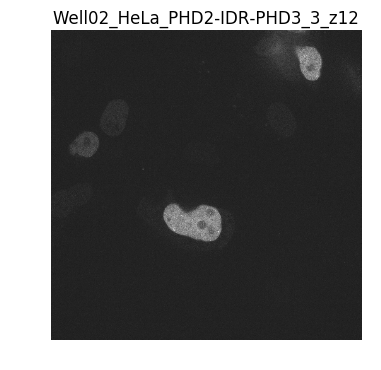

In [10]:
plt.imshow(GFP_stack[z], cmap='gray')
plt.axis('off')
plt.title(stackname)

#Note uneven illumination

In [38]:
#[1] Threshold by Gloabl Mean
def meanThreshStack(stack):
    return stack > stack.mean()

In [39]:
import mahotas as mh  #used for filtering and labeling binary regions

#[2] 3D Gaussian Filter then mean
def gaussianThreshStack(stack, gaussian_filter_size=3):
    #By default gaussian_filter_size is 3
    smoothed_stack = mh.gaussian_filter(stack, gaussian_filter_size) 
    return smoothed_stack > smoothed_stack.mean()

In [40]:
import numpy as np
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

#[4] Try local Otsu (Slow)
def localOtsuStack(stack, radius = 50):
#By default the radius is 50

    selem = disk(radius)

#Input must be a 2D array
    if len(stack.shape)>2:
        
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            #print(z)
            local_otsu = rank.otsu(frame, selem)
            mask[z] = frame >= local_otsu
        return mask
    else:
        local_otsu = rank.otsu(stack, selem)         
        print 'Input is not a 3D stack'
        return stack >= local_otsu

In [41]:
#Call precise localOtsu
#mask4=localOtsuStack(Hoechst_stack)

In [42]:
##Threshold a 3D stack (SLOW!)
def stack2mask(stack, gaussian_filter_size=3, radius = 50):
#By default gaussian_filter_size=3 for mask 2, and radius = 50 for mask4.
    
    #Calculate gaussianThresh 'mask2'
    mask2=gaussianThreshStack(Hoechst_stack, gaussian_filter_size)
         
    #Calculate localOtsu 'mask4'
    mask4=localOtsuStack(stack, radius)

    #Remove background by intersecting with 3D gaussian filter mask
    mask5 = np.logical_and(mask2, mask4)
    
    return [mask2, mask4, mask5]    

**Generate masks**

In [77]:
##Generate threshold masks from Hoechst stack
#Takes ~1.5h
t0=time.time()
[mask2, mask4, mask5] = stack2mask(Hoechst_stack)

##Save masks, it takes hours to run each file
np.save(mask2path, mask2)
np.save(mask4path, mask4)
np.save(mask5path, mask5)

t1=time.time()

print t1-t0

5624.05000019


In [43]:
##Save mask4, it takes forever to run
#np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4_Mask4', mask4)

In [44]:
##Remove background by intersecting with 3D gaussian filter mask
#mask5 = np.logical_and(mask2, mask4)

In [45]:
##Save mask5
#np.save('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well03_HeLa_PHD2-IDR-PHD3[W1625A]_4_Mask5', mask5)

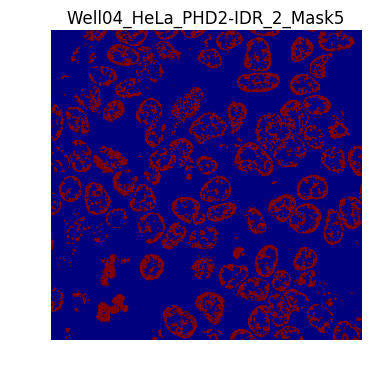

In [46]:
plt.imshow(mask5[0])
plt.axis('off')
plt.title(mask5name)

In [68]:
from skimage.filters import threshold_otsu, threshold_adaptive
#block_size and offset are optional arguments, with default parameters 35 and -20 respectively   
#block_size = Width of neighbourhood in pixels. Default was 35
#offset = Constant subtracted from mean. Default was 10

#[3] Try local threshold
def localThreshStack(stack, block_size = 35, offset = -20):

    #Must be a 2D array
    if len(stack.shape)>2:
        mask=np.zeros_like(stack)

        for z, frame in enumerate(stack):
            mask[z] = threshold_adaptive(frame, block_size, 'mean', offset)
        return mask     
    else:
        print 'Input is not a 3D stack'
        return threshold_adaptive(stack, block_size, 'mean', offset)
     

In [ ]:
import numpy as np
import mahotas as mh  #used for filtering and labeling binary regions
from skimage.filters import threshold_otsu, threshold_adaptive

#Threshold the image
def stack2thres(stack, gaussian_filter_size, local_Otsu_radius)

    #[1] Mean
    #mask1=stack>stack.mean()

    #[2] 3D Gaussian Filter then mean
    smoothed_stack=mh.gaussian_filter(stack, 3)
    mask2 = smoothed_stack > smoothed_stack.mean()

    #[3] Try local threshold

    #Must be a 2D array
#     if len(stack.shape)>2:
#         mask3=np.zeros_like(stack)
#         block_size = 35 #Width of neighbourhood in pixels. Default was 35
#         offset = -20    #Constant subtracted from mean. Default was 10

#         for z, frame in enumerate(stack):
#             mask3[z] = threshold_adaptive(frame, block_size, 'mean', offset)
#     else:
#         mask3 = threshold_adaptive(stack, block_size, 'mean', offset)

    #[4] Try local Otsu (Slow)
    #from skimage.morphology import disk
    #from skimage.filters import threshold_otsu, rank
    #from skimage.util import img_as_ubyte

    #Select a single test image from the stack
    img = Hoechst_stack[4]

    radius = 50              #Default is 15, which looks good. 
                             #Tried nuclei size radius ~50, Bigger border around nuceli
                             #Tried nuclei size radius ~100. 
                             #Also tried r=5, worse for bright nuclei clustering
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    local_otsu_mask= img >= local_otsu

    #For comparison
    #threshold_global_otsu = threshold_otsu(img)
    #global_otsu = img >= threshold_global_otsu

In [ ]:
plt.imshow(mask3[4], cmap='gray')
plt.axis('off')
plt.title('Mask 3, Local Thresholding')

In [ ]:
plt.imshow(local_otsu_mask, cmap='gray')
plt.axis('off')
plt.title('Local Otsu')

In [ ]:
plt.imshow(global_otsu, cmap='gray')
plt.axis('off')
plt.title('Global Otsu')

In [ ]:
#Try local otsu ----- THIS WILL BE VERY SLOW
#Must be a 2D array
mask4=np.zeros_like(Hoechst_stack)

radius = 50            #default is 15
selem = disk(radius)

for z, frame in enumerate(Hoechst_stack):
    print(z)
    local_otsu = rank.otsu(frame, selem)
    mask4[z] = frame >= local_otsu

In [ ]:
##Compare Threshold methods
images=[mask1, mask2, mask3]
titles=("Stack Mean", "Gaussian Filter", "Adaptive Threshold", "Local Otsu")

for x in range(len(images)):
    plt.subplot(1,3,x+1),plt.imshow(images[x][4],'gray')
    plt.subplot(1,3,x+1),plt.title(titles[x])
    plt.subplot(1,3,x+1),plt.axis('off')

In [ ]:
#Compare after fill_holes
from scipy.ndimage import morphology

## Process binary array frame by frame:
def fill_3D(array):
    stack=np.zeros_like(array)
    for z, frame in enumerate(array):
        filled = morphology.binary_fill_holes(frame).astype(int)
        stack[z] = filled
    return stack

In [ ]:
#Calculate filled masks for each technique
filled_masks=np.zeros_like(images)

for b in range(len(images)):
    filled=fill_3D(images[b])
    filled_masks[b]=filled

In [ ]:
##Compare filled masks for each technique
titles=("Stack Mean", "Gaussian Filter", "Adaptive Threshold", "Local Otsu")

for x in range(len(filled_masks)):
    plt.subplot(1,3,x+1),plt.imshow(filled_masks[x][5],'gray')
    plt.subplot(1,3,x+1),plt.title(titles[x])
    plt.subplot(1,3,x+1),plt.axis('off')